In [2]:
import numpy as np
import numba
from numba import jit
import pydicom
import matplotlib.pyplot as plt
from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vcenter=0.)
import imageio
from scipy import interpolate
from skimage.filters import gaussian
plt.style.use(['science', 'notebook'])
import tomopy

from scipy.interpolate import RectBivariateSpline
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon, rescale, rotate
from skimage.measure import profile_line
from skimage.restoration import denoise_nl_means, estimate_sigma, richardson_lucy, unsupervised_wiener, wiener  
#import functions

In [3]:
lam = 500
n = 400
L_val = 1/2
B_val = 1/5

Read original CT image and normalize to get reasonable attenuation coefficient $\mu(x,y)$

In [4]:
def normalize_phantom(A, p=0.5):
    n = A.shape[0]
    mu = -np.log(p)/n
    m = np.mean(A[A>0])
    return A*mu/m

A1 = imageio.imread('images/phantom1.png').sum(axis=2)
A2 = imageio.imread('images/phantom2.png').sum(axis=2)
A3 = imageio.imread('images/phantom3.png').sum(axis=2)
A4 = imageio.imread('images/phantom4.png').sum(axis=2)
A1_norm = normalize_phantom(A1, p=0.5)
A2_norm = normalize_phantom(A2, p=0.5)
A3_norm = normalize_phantom(A3, p=0.5)
A4_norm = normalize_phantom(A4, p=0.5)

A = A1
A_norm = A1_norm

Get all tumours and append to single array

In [5]:
Ts = np.array([np.asarray(imageio.imread(f'images/t{i}.png').sum(axis=2) > 0) for i in range(1,24)])
n = A1.shape[0]
T = Ts.sum(axis=0).astype(bool)
T_masked = np.ma.masked_where(~T, T)

Add live and background and remove any overlapping tumours from liver

In [6]:
L = np.asarray(imageio.imread(f'images/liv.png').sum(axis=2))>260
B = np.asarray(imageio.imread(f'images/background.png').sum(axis=2))>260

Ts_non_overlap = []
for T in Ts:
    if not np.any(T*L):
        Ts_non_overlap.append(T)
T = np.array(Ts_non_overlap).sum(axis=0).astype(bool)
T_masked = np.ma.masked_where(~T, T)
B = B^(T+L)

In [7]:
T_masked = np.ma.masked_where(~T, T)
L_masked = np.ma.masked_where(~L, L)
B_masked = np.ma.masked_where(~B, B)
masks = [T_masked, L_masked, B_masked]
mask_names = ['T', 'L', 'B']

Get tumour distribution by smoothing the activity.

In [9]:
def get_tumour_dist(T, sigma=3):
    U = gaussian(T, sigma=3)
    U[~T]=0
    return U

U = get_tumour_dist(T, sigma=3)
U[L] += L_val
U[B] += B_val

In [10]:
@numba.jit("f8[:](f8[:,:], i8[:,:], f8[:], i8, i8)", nopython=True, nogil=True)
def compute_prob_of_detections(A, decay_points, decay_angles, n=400, num=1000):
    diameter = np.sqrt(2*n**2)
    dL = 2*diameter / num
    prob_of_detections = []
    for j in range(len(decay_points)):
        dp = decay_points[j]; da = decay_angles[j]
        # Get initial and final points
        x1 = dp[0] - np.cos(da)* diameter
        x2 =  dp[0] + np.cos(da)* diameter
        y1 = dp[1] - np.sin(da)* diameter
        y2 =  dp[1] + np.sin(da)* diameter
        dx = (x2 - x1)/num
        dy = (y2 - y1)/num
        x = x1
        y = y1
        mux = 0
        for i in range(num):
            if (x>0) * (x<n) * (y>0) * (y<n):
                mux += A[int(x),int(y)]*dL
            x+=dx; y+=dy
        prob_of_detections.append(np.exp(-mux))
    return np.array(prob_of_detections)

@numba.jit("f8[:,:](f8[:], f8[:], f8[:,:], i8)", nopython=True, nogil=True)
def estimate_prob_of_detections_sino(rs, thetas, A, num=1000):
    n = A.shape[0]
    diameter = np.sqrt(2*n**2)
    dL = 2*diameter / num
    # from histogram edges to centers
    thetas = thetas[:-1]+(thetas[1]-thetas[0])/2
    rs = rs[:-1]+0.5
    prob_of_detections = np.zeros((len(rs),len(thetas)), dtype=np.float64)
    for i,r in enumerate(rs):
        for j,theta in enumerate(thetas):
            x = r*np.cos(theta+np.pi/2) + n//2
            y = r*np.sin(theta+np.pi/2) + n//2
            x1 = x - np.cos(theta)* diameter
            x2 =  x + np.cos(theta)* diameter
            y1 = y - np.sin(theta)* diameter
            y2 =  y + np.sin(theta)* diameter
            dx = (x2 - x1)/num
            dy = (y2 - y1)/num
            x = x1
            y = y1
            mux = 0
            for k in range(num):
                if (x>0) * (x<n) * (y>0) * (y<n):
                    mux += A[int(x),int(y)]*dL
                x+=dx; y+=dy
            prob_of_detections[i][j] = np.exp(-mux)
    return prob_of_detections

def compute_recon_tomopy(sino, thetas, algo_name, **kwargs):
    proj = np.expand_dims(sino.T, axis=1)
    thetas = thetas[:-1]+np.diff(thetas)[0]/2
    im = tomopy.recon(proj, thetas, algorithm=algo_name, **kwargs)
    return im[0]*len(thetas)

# raw for raw counts
# im for image
# og for original (lambda used to get image)

class PETImage:
    def __init__(self, CT_im, PET_og):
        self.CT_im = CT_im
        self.PET_og = PET_og
        self.n = self.CT_im.shape[0]
    def generate_PET_raw(self):
        self.PET_raw = np.random.poisson(lam=self.PET_og, size=self.PET_og.shape)
        self.PET_raw_ang = np.random.uniform(size=self.PET_raw.sum())*2*np.pi
        self.PET_raw_pts = np.repeat(np.argwhere(self.PET_raw), self.PET_raw[self.PET_raw>0], axis=0)
    def generate_PET_im(self):
        prob_of_detections = compute_prob_of_detections(self.CT_im, self.PET_raw_pts, self.PET_raw_ang, n=self.n, num=1000)
        xs, ys = self.PET_raw_pts.T
        self.decay_mask = prob_of_detections > np.random.uniform(size=len(prob_of_detections))
        self.PET_im,_,_ = np.histogram2d(xs[self.decay_mask], ys[self.decay_mask], bins=[np.arange(-0.5,self.n+0.5),np.arange(-0.5,self.n+0.5)])
    def generate_PET_sino(self,n_theta_bins=61):
        center = (self.n//2, self.n//2)
        xs, ys = self.PET_raw_pts[self.decay_mask].T
        thetas = self.PET_raw_ang[self.decay_mask]
        rs = (xs - center[0]) * np.cos(thetas+np.pi/2) + (ys - center[1]) * np.sin(thetas+np.pi/2)
        self.PET_im_sino_rs_bins = np.arange(-self.n//2-0.5, self.n//2+0.5, 1)
        self.PET_im_sino_theta_bins = np.linspace(0,2*np.pi,n_theta_bins)
        self.PET_im_sino,_,_ = np.histogram2d(rs,thetas, bins=[self.PET_im_sino_rs_bins, self.PET_im_sino_theta_bins])
    def get_probability_sinogram(self):
        self.PET_im_sino_prob = estimate_prob_of_detections_sino(self.PET_im_sino_rs_bins,
                                                                 self.PET_im_sino_theta_bins,
                                                                 self.CT_im, num=1000)
    def get_recon_data(self, algo_names, masks, masks_name, correction, num_iters):
        self.recon_datas = {}
        sino = self.PET_im_sino/self.PET_im_sino_prob
        for algo_name, num_iter in zip(algo_names, num_iters):
            RD = ReconData(algo_name, masks, masks_name, correction,
                           num_iter, self.PET_og, sino,
                            self.PET_im_sino_theta_bins)
            RD.MSE_data()
            self.recon_datas[algo_name] = RD
    
class ReconData:
    def __init__(self, algo_name, masks, mask_names, correction, num_iter, PET_og, sino, thetas, **kwargs):
        self.algo_name = algo_name
        self.masks = masks
        self.mask_names = mask_names
        self.correction = correction
        self.num_iter = num_iter
        self.kwargs = kwargs
        self.PET_og = PET_og
        self.sino = sino
        self.thetas = thetas
        
    def MSE_data(self):
        self.data = {}
        for name in self.mask_names:
            self.data[name] = {'MSE': [], 'VAR': [], 'BIAS':[]}
        self.MSE_bests = [np.inf]*len(masks)
        self.iter_bests = [0]*len(masks)
        self.im_bests = [0]*len(masks)
        for i in range(self.num_iter):
            if i==0:
                im = compute_recon_tomopy(self.sino, self.thetas, self.algo_name,
                                          num_iter=1, **self.kwargs);
            else:
                im = compute_recon_tomopy(self.sino, self.thetas, self.algo_name,
                                          num_iter=1, init_recon=np.expand_dims(im, axis=0)/len(self.thetas),
                                          **self.kwargs);
            
            if self.correction=='wiener':
                im_corr = wiener(im, get_gaus_kernel(9, 0.5), balance=14.5, clip=False)
            elif self.correction=='nlm':
                im_corr = denoise_nl_means(im, patch_size=10, patch_distance=30, h=30)
            else:
                im_corr = im
            for j, (M, name) in enumerate(zip(masks, mask_names)):
                MSE = np.mean((self.PET_og[M]-im_corr[M])**2)
                VAR = np.var(self.PET_og[M]-im_corr[M])
                BIAS = np.mean(self.PET_og[M]-im_corr[M])
                if MSE<self.MSE_bests[j]:
                    self.MSE_bests[j] = MSE
                    self.iter_bests[j] = i
                    self.im_bests[j] = im_corr.copy()
                self.data[name]['MSE'].append(MSE)
                self.data[name]['VAR'].append(VAR)
                self.data[name]['BIAS'].append(BIAS)
        self.im_final = im_corr

In [11]:
p = PETImage(A1_norm, 500*U)

In [12]:
p.generate_PET_raw()

In [13]:
p.generate_PET_im()

In [14]:
p.generate_PET_sino()

In [15]:
p.get_probability_sinogram()

In [16]:
p.get_recon_data(['art'], masks, mask_names, correction=None, num_iters=[15])

Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...


# Plots for Paper

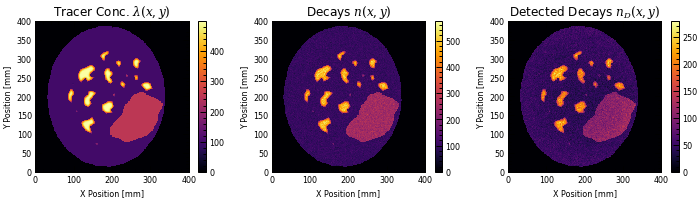

In [17]:
fig, ax = plt.subplots(1,3,figsize=(10,3))
im = ax[0].pcolor(500*U, cmap='inferno')
c = plt.colorbar(im, ax=ax[0])
c.ax.tick_params(axis='y', labelsize=8)
ax[0].set_title('Tracer Conc. $\lambda(x,y)$', fontsize=12)
im = ax[1].pcolor(p.PET_raw, cmap='inferno')
c = plt.colorbar(im, ax=ax[1])
c.ax.tick_params(axis='y', labelsize=8)
ax[1].set_title('Decays $n(x,y)$', fontsize=12)
im = ax[2].pcolor(p.PET_im, cmap='inferno')
c = plt.colorbar(im, ax=ax[2])
c.ax.tick_params(axis='y', labelsize=8)
ax[2].set_title('Detected Decays $n_D(x,y)$', fontsize=12)
[a.tick_params(axis='x', labelsize=8) for a in ax]
[a.tick_params(axis='y', labelsize=8) for a in ax]
[a.set_xlabel('X Position [mm]', fontsize=8) for a in ax]
[a.set_ylabel('Y Position [mm]', fontsize=8) for a in ax]
fig.tight_layout()
#plt.savefig('images/tumours.png', dpi=200)
plt.show()

In [18]:
ps = [PETImage(A, 500*U) for A in [A1_norm, A2_norm, A3_norm, A4_norm]]
for i,pi in enumerate(ps):
    print(i)
    pi.generate_PET_raw()
    pi.generate_PET_im()

0
1
2
3


<ipython-input-19-5d19880d7be4>:3: RuntimeWarning: invalid value encountered in true_divide
  q = (ps[i].PET_im/np.mean(ps[i].PET_im) - ps[i].PET_raw/np.mean(p.PET_raw))/(ps[i].PET_og/np.mean(ps[i].PET_og))


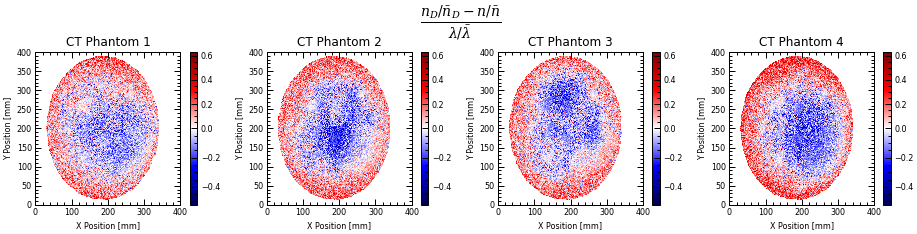

In [19]:
fig, ax = plt.subplots(1,4,figsize=(13,3))
for i in range(4):
    q = (ps[i].PET_im/np.mean(ps[i].PET_im) - ps[i].PET_raw/np.mean(p.PET_raw))/(ps[i].PET_og/np.mean(ps[i].PET_og))
    im = ax[i].pcolor(q, cmap='seismic', norm=divnorm)
    c = plt.colorbar(im, ax=ax[i])
    c.ax.tick_params(axis='y', labelsize=8)
    ax[i].set_title(f'CT Phantom {i+1}', fontsize=12)
[a.tick_params(axis='x', labelsize=8) for a in ax]
[a.tick_params(axis='y', labelsize=8) for a in ax]
[a.set_xlabel('X Position [mm]', fontsize=8) for a in ax]
[a.set_ylabel('Y Position [mm]', fontsize=8) for a in ax]
fig.tight_layout()
fig.suptitle(x=0.5,y=1.1,t='$\\frac{n_D/\\bar{n}_D - n/\\bar{n}}{\lambda/\\bar{\lambda}}$',ha='center', fontsize=20)
#plt.savefig('images/tumours.png', dpi=200)
plt.show()

# Other Stuff

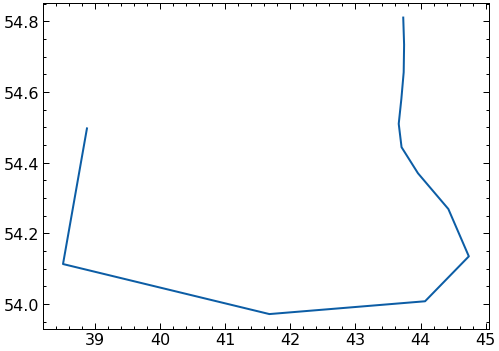

In [20]:
plt.plot(p.recon_datas['art'].data['T']['BIAS'][2:],np.sqrt(p.recon_datas['art'].data['T']['VAR'][2:]))